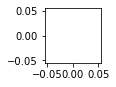

In [14]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# force plt on windows 10
import matplotlib.pyplot as plt
plt.figure(figsize=(1,1))
plt.plot()

import sys
sys.path.append("..")

import torch
import torch.nn as nn
import numpy as np
import aggets.ds.window as window
import aggets.ds.hyper_f_load as hfl
import aggets.ds.window as window

## DISABLE THIS
import warnings
warnings.filterwarnings("ignore")

In [2]:
# role:
#     background:
#         - ds-ml global logic in krakow, someone who will be leading the activity
#         - preseales
#         - 
#     responsibilities:
#         - preseales
#         - may or may not involve beeing in a real project
#         - strategic stuff, reseaearch
#         - develope expertise in krakow
#         - huge amount of data and dont know what to do
#         - group of ppl working on reaserch 
#         - preseales/researches/poc - catchup some skills i don't have etc
#         - practices organization includes ppl in this roles working on different stuff:
#         - comunity in crakow that we want to grow
#         - mentoring
#         - data/ml/ai ~10ppl in KRK but it is gona grow ~ 300ppl
#         - project not defined yet
#         - fleet mngment huge ml algorithm etc
        
#         - any questions just ask karolina, also clarifications
        
        

In [3]:
import aggets.ds.moving as moving
data = hfl.load_df()
wg = moving.WindowGenerator(data['df'], 10000, label_columns=['class'], sampling=0.01)

In [4]:
import aggets.ds.aggregate2 as aggregate
import aggets.ds.hyper_f_load as hyper_f_load

CONV_WIDTH = 8
LABEL_WIDTH = 57
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1) 

data = hyper_f_load.load_discrete()
# wg = aggregate.WindowGenerator(df=df, 
#                               window_stride=None,
#                               window_size=10,
#                               sample_frac=0.1,
#                               sampling=10,
#                               label_columns=['class'])

wg = aggregate.WindowGenerator(chunk_size=500, samples=5, sample_frac=0.8,                         
                               train_df = data['train'],
                               val_df = data['val'],
                               test_df = data['test'],
                               input_width=INPUT_WIDTH, label_width=10, shift=1,
                               label_columns=['class'],
                               label_stride=1)

print(INPUT_WIDTH, LABEL_WIDTH)

64 57


In [5]:
# wg.init_structures()
wg.aggregate_slice = slice(0, 102)
wg.source_slice = slice(102, 102+11)
wg.target_slice = slice(102+11, 102+11+11)


In [6]:
import aggets.util as util
# util.save(wg, path='window_01.bin') # chunk_size=50, samples=10, sample_frac=0.3
# util.save(wg, path='window_02.bin') # chunk_size=100, samples=5, sample_frac=0.8,
# util.save(wg, path='window_03.bin') # chunk_size=500, samples=5, sample_frac=0.8,
wg_tmp = util.load(path='window_03.bin')

In [7]:
wg_tmp.aggregate_slice = slice(0, 102)
wg_tmp.source_slice = slice(102, 102+11)
wg_tmp.target_slice = slice(102+11, 102+11+11)
wg_tmp.label_stride = 55


10

In [8]:
import aggets.model.simple as simple
inp = torch.randn(32, 102, 65)
net = simple.n_conv_1d(102, conv_layers=1, pool_width=5, pool_stride=2, conv_width=8)
print(net[1])
print(net[1](inp).shape)
net(torch.transpose(inp, 1,2)).shape

Sequential(
  (0): Conv1d(102, 51, kernel_size=(8,), stride=(1,))
  (1): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
)
torch.Size([32, 51, 27])


torch.Size([32, 27, 51])

In [211]:
import aggets.model.aggregate as m_agg
import aggets.train as train
# +1 is for BIAS
model_a = m_agg.LrConv(conv_features=102, conv_width=10, lr_features=10+1, conv_hidden=16, mlp_layers=2, resid=True)
model_a = m_agg.LrConv(conv_features=102, conv_width=10, lr_features=10+1, conv_hidden=8, mlp_layers=2, resid=True)

model_b = m_agg.LrNConv(ts_features=102, lr_features=10+1, conv_width=8,
                        conv_layers=2,
                        ts_conv_pool_stride=2, ts_conv_pool_width=3, 
                        lr_conv_pool_stride=2, lr_conv_pool_width=3,
                        mlp_width=16, mlp_layers=3, lr_conv_out_feature_div=1.1,
                        out_features=10+1)

model_c = m_agg.CombinedLrNConv(ts_features=102, lr_features=10+1, 
                                conv_width=8, conv_layers=2,
                                conv_pool_stride=2, conv_pool_width=3, 
                                conv_fc_layers=2, conv_out_feature_div=2,
                                out_features=10+1)

model_d = m_agg.CombinedLrNConv(ts_features=102, lr_features=10+1, 
                                conv_width=8, conv_layers=2,
                                conv_pool_stride=2, conv_pool_width=3, 
                                conv_fc_layers=2, conv_out_feature_div=2,
                                out_features=10+1)
# print(model_a)
print('---')
# print(model_b)
print('---')
print(model_c)

---
---
CombinedLrNConv(
  (conv): Sequential(
    (0): SwapDims()
    (1): Sequential(
      (0): Conv1d(113, 56, kernel_size=(8,), stride=(1,))
      (1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm1d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Dropout(p=0.5, inplace=False)
      (5): Conv1d(56, 28, kernel_size=(8,), stride=(1,))
      (6): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Dropout(p=0.5, inplace=False)
    )
    (2): SwapDims()
    (3): Sequential(
      (0): Linear(in_features=28, out_features=28, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=28, out_features=11, bias=True)
    )
  )
)


epoch 0 batch 200 loss=0.00263, MTL=0.00658, MVL=0.236				
*epoch 1 batch 400 loss=0.00244, MTL=0.00267, MVL=0.212				
*epoch 2 batch 600 loss=0.00255, MTL=0.00261, MVL=0.209				
*epoch 3 batch 800 loss=0.00268, MTL=0.00261, MVL=0.209				
*epoch 4 batch 1000 loss=0.00286, MTL=0.00263, MVL=0.209				
epoch 5 batch 1200 loss=0.00281, MTL=0.00261, MVL=0.209				
*epoch 6 batch 1400 loss=0.00295, MTL=0.00261, MVL=0.209				
epoch 7 batch 1600 loss=0.00245, MTL=0.00261, MVL=0.21				
epoch 8 batch 1800 loss=0.00301, MTL=0.00261, MVL=0.209				
epoch 9 batch 2000 loss=0.00244, MTL=0.00259, MVL=0.209				
epoch 10 batch 2200 loss=0.00271, MTL=0.0026, MVL=0.209				
epoch 11 batch 2400 loss=0.00232, MTL=0.00261, MVL=0.209				
epoch 12 batch 2600 loss=0.00254, MTL=0.00262, MVL=0.21				
*epoch 13 batch 2800 loss=0.00272, MTL=0.00263, MVL=0.209				
epoch 14 batch 3000 loss=0.00266, MTL=0.0026, MVL=0.209				
epoch 15 batch 3200 loss=0.00234, MTL=0.00254, MVL=0.209				
epoch 16 batch 3400 loss=0.00257, MT

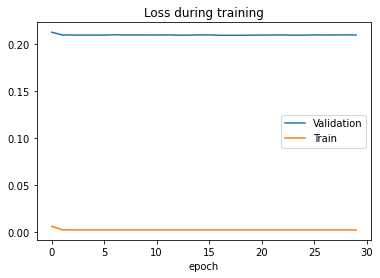

RuntimeError: Error(s) in loading state_dict for CombinedLrNConv:
	Missing key(s) in state_dict: "conv.1.2.running_mean", "conv.1.2.running_var", "conv.1.5.weight", "conv.1.5.bias", "conv.1.7.weight", "conv.1.7.bias", "conv.1.7.running_mean", "conv.1.7.running_var", "conv.3.3.weight", "conv.3.3.bias". 
	Unexpected key(s) in state_dict: "conv.3.2.weight", "conv.3.2.bias". 
	size mismatch for conv.1.2.weight: copying a param with shape torch.Size([28, 56, 8]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for conv.1.2.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([56]).

In [212]:
def train_lr_decay(model, window, handler=None):
    handler = None
    for lr in [0.001, 0.0001, 0.00005]:#, #0.000001, 0.0000005]:
        if handler:
            handler.best()
        plt.figure()
        handler = train.train_window_model(model, window, log_every=200, max_epochs=100, 
                                           patience=10, lr=lr, weight_decay=0.1, model_handler=handler)
        plt.show()
        
    return handler

wg_tmp.label_stride = 55
handler_c = train_lr_decay(model_c, wg_tmp)

epoch 0 batch 100 loss=0.00288, MTL=0.00433, MVL=0.272				
epoch 0 batch 200 loss=0.00257, MTL=0.0035, MVL=0.272				
save best
epoch 1 batch 300 loss=0.00239, MTL=0.00253, MVL=0.239				
epoch 1 batch 400 loss=0.00241, MTL=0.00246, MVL=0.239				
save best
epoch 2 batch 500 loss=0.00196, MTL=0.00211, MVL=0.231				
epoch 2 batch 600 loss=0.00176, MTL=0.00193, MVL=0.231				
save best
epoch 3 batch 700 loss=0.00153, MTL=0.00156, MVL=0.223				
epoch 3 batch 800 loss=0.00143, MTL=0.00152, MVL=0.223				
save best
epoch 4 batch 900 loss=0.00132, MTL=0.00134, MVL=0.22				
epoch 4 batch 1000 loss=0.00123, MTL=0.00132, MVL=0.22				
save best
epoch 5 batch 1100 loss=0.00123, MTL=0.00122, MVL=0.217				
epoch 5 batch 1200 loss=0.0012, MTL=0.0012, MVL=0.217				
save best
epoch 6 batch 1300 loss=0.00111, MTL=0.00111, MVL=0.213				
epoch 6 batch 1400 loss=0.0011, MTL=0.00111, MVL=0.213				
save best
epoch 7 batch 1500 loss=0.00109, MTL=0.00108, MVL=0.21				
epoch 7 batch 1600 loss=0.00102, MTL=0.00107, 

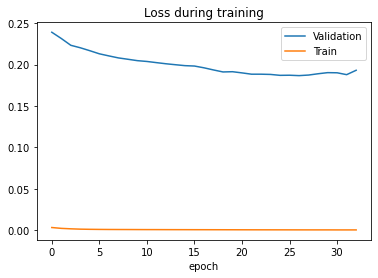

In [180]:
wg_tmp.label_stride = 9
state_a = train.train_window_model(model_a, wg_tmp, log_every=100, max_epochs=4000, patience=5, lr=0.0005)
plt.show()

epoch 0 batch 100 loss=0.00116, MTL=0.00116, MVL=0.189				
epoch 0 batch 200 loss=0.00116, MTL=0.00115, MVL=0.189				
save best
epoch 1 batch 300 loss=0.00106, MTL=0.00114, MVL=0.189				
epoch 1 batch 400 loss=0.00112, MTL=0.00114, MVL=0.189				
save best
epoch 2 batch 500 loss=0.00112, MTL=0.00114, MVL=0.189				
epoch 2 batch 600 loss=0.00115, MTL=0.00113, MVL=0.189				
save best
epoch 3 batch 700 loss=0.00117, MTL=0.00113, MVL=0.189				
epoch 3 batch 800 loss=0.00103, MTL=0.00113, MVL=0.189				
save best
epoch 4 batch 900 loss=0.00108, MTL=0.00112, MVL=0.188				
epoch 4 batch 1000 loss=0.00108, MTL=0.00112, MVL=0.188				
save best
epoch 5 batch 1100 loss=0.00103, MTL=0.00112, MVL=0.188				
epoch 5 batch 1200 loss=0.00106, MTL=0.00111, MVL=0.188				
save best
epoch 6 batch 1300 loss=0.00107, MTL=0.0011, MVL=0.188				
epoch 6 batch 1400 loss=0.00109, MTL=0.0011, MVL=0.188				
save best
epoch 7 batch 1500 loss=0.00113, MTL=0.00111, MVL=0.188				
epoch 7 batch 1600 loss=0.00105, MTL=0.00

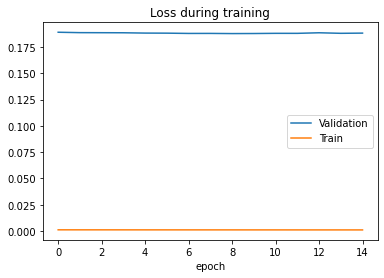

In [85]:
state_a.best()
state_a = train.train_window_model(model_a, wg_tmp, log_every=100, max_epochs=4000, patience=5, lr=0.00005)
plt.show()

epoch 0 batch 100 loss=0.000572, MTL=0.000605, MVL=0.186				
epoch 0 batch 200 loss=0.000594, MTL=0.000604, MVL=0.186				
save best
epoch 1 batch 300 loss=0.000594, MTL=0.000601, MVL=0.187				
epoch 1 batch 400 loss=0.000623, MTL=0.000603, MVL=0.187				
save best
epoch 2 batch 500 loss=0.000581, MTL=0.000601, MVL=0.187				
epoch 2 batch 600 loss=0.000629, MTL=0.000602, MVL=0.187				
epoch 3 batch 700 loss=0.000634, MTL=0.000604, MVL=0.187				
epoch 3 batch 800 loss=0.000634, MTL=0.000602, MVL=0.187				
save best
epoch 4 batch 900 loss=0.000631, MTL=0.000605, MVL=0.187				
epoch 4 batch 1000 loss=0.000609, MTL=0.0006, MVL=0.187				
epoch 5 batch 1100 loss=0.000583, MTL=0.0006, MVL=0.187				
epoch 5 batch 1200 loss=0.000561, MTL=0.0006, MVL=0.187				
epoch 6 batch 1300 loss=0.000576, MTL=0.000601, MVL=0.187				
epoch 6 batch 1400 loss=0.000608, MTL=0.0006, MVL=0.187				
epoch 7 batch 1500 loss=0.000581, MTL=0.000607, MVL=0.187				
epoch 7 batch 1600 loss=0.0006, MTL=0.000599, MVL=0.187		

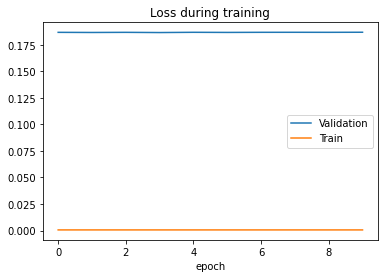

In [181]:
state_a.best()
state_a = train.train_window_model(model_a, wg_tmp, log_every=100, max_epochs=4000, patience=5, lr=0.000005)
plt.show()

TypeError: 'NoneType' object is not callable

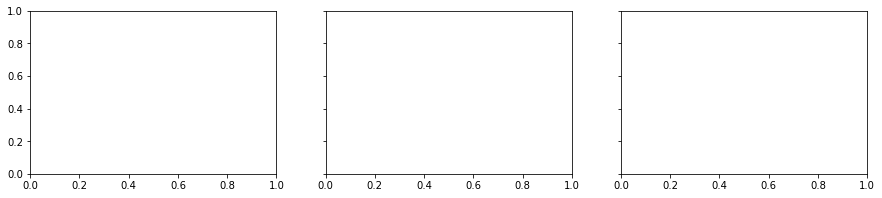

In [182]:
def plot(set_type, model):
    rolling = 300 if set_type == 'train' else 100
    wg_tmp.plot(model=model, model_data_fn=None, last_train=False, lr0=False, 
                set_type=set_type, no_lr=True, model_resid=True, model_name='resid', rolling=rolling)
    wg_tmp.plot(model=model, model_data_fn=None, last_train=False, lr0=False, 
                set_type=set_type, no_lr=True, model_resid=False, rolling=rolling)
    wg_tmp.plot(model=None, model_data_fn=None, last_train=False, lr0=False, lr_t0=set_type=='train',
                set_type=set_type, no_lr=False, model_resid=False, rolling=rolling)
# state_a.last()
# wg_tmp.plot(model=model_a, model_data_fn=None, last_train=False, lr0=False, set_type='val', no_lr=True)
state_a.best()
_, axs = plt.subplots(ncols=3, nrows=1, sharey='all', figsize=(15,3))
plt.sca(axs[0])
plot('train', model_a)
plt.sca(axs[1])
plot('val', model_a)
plt.sca(axs[2])
plot('test', model_a)

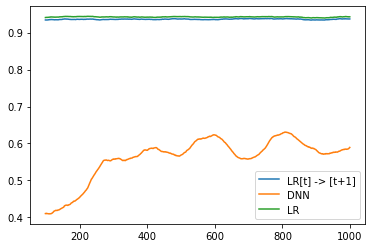

In [17]:
from sklearn import linear_model
import sklearn.metrics as metrics 
import matplotlib.pyplot as plt
import pandas as pd

def split_chunks(df, wg):
    chunks = df.shape[0] // wg.chunk_size
    result = []
    for chunk_id in range(chunks):
        result.append(df[chunk_id * wg.chunk_size:(chunk_id + 1) * wg.chunk_size])
        
    return result

train_df = split_chunks(wg_tmp.train_df, wg_tmp)
lr = linear_model.LogisticRegression()
lr.fit(train_df[1][wg_tmp.value_columns], train_df[1][wg_tmp.label_columns])
    
def measure_lr(lr, dat, rolling=100, weights=None):
    lr_aucs = []
    for lrp, df in dat:
        if weights != None:
            lr.coef_ = weights[:-1].reshape(1, -1).detach().numpy()
            lr.intercept_ = weights[-1].detach().numpy()
        else:
            lr.coef_ = lrp[:-1].reshape(1, -1).detach().numpy()
            lr.intercept_ = lrp[-1].detach().numpy()
        yhat = lr.predict_proba(df[wg_tmp.value_columns])
        lr_aucs.append(metrics.roc_auc_score(df[wg_tmp.label_columns], yhat[:, 1]))
    return pd.DataFrame(data=lr_aucs).rolling(rolling).mean()

def measure_model(model, dat, lr, rolling=100):
    model.eval()
    with torch.no_grad():
        model_aucs = []
        for (x, target), df in dat:
#             lrhat = model.forward(x).detach().numpy().reshape(-1) + target.detach().numpy().reshape(-1)
#             lrhat = target.detach().numpy().reshape(-1)
            lrhat = model.forward(x).detach().numpy().reshape(-1)
            lr.coef_ = lrhat[:-1].reshape(1, -1)
            lr.intercept_ = lrhat[-1]
            
            yhat = lr.predict_proba(df[wg_tmp.value_columns])
            
            model_aucs.append(metrics.roc_auc_score(df[wg_tmp.label_columns], yhat[:, 1]))
        return pd.DataFrame(data=model_aucs).rolling(rolling).mean()
    
sample_len = 1000
    
dat = list(zip(wg_tmp.train_lr[:-1, 0, :], train_df[1:]))
plt.plot(measure_lr(lr, dat[:sample_len]), label='LR[t] -> [t+1]')

def prepare_model_input(wg, model):
    ts_chunks = []
    lr_pred = []
    x = []
    for k in range(len(wg.train_agges) - (model.conv_width + 1)):
        agg = wg.train_agges[k:k + model.conv_width, 0, :]
        lr_v  = wg.train_lr[k:k + model.conv_width, 0, :]
        target  = wg.train_lr[k + model.conv_width, 0, :]
        x.append(((agg.reshape(1, *agg.shape), lr_v.reshape(1, *lr_v.shape)), target))
        
    return x

x = prepare_model_input(wg_tmp, model_a)

dat = list(zip(x[:-1], train_df[1:]))
plt.plot(measure_model(model_a, dat[:sample_len], lr), label='DNN')

# dat = list(zip(wg_tmp.train_lr[:-1, 0, :], train_df[:-1]))
# plt.plot(measure_lr(lr, dat[:sample_len], weights=wg_tmp.train_lr[0, 0, :]), label='first LR')

dat = list(zip(wg_tmp.train_lr[:-1, 0, :], train_df[:-1]))
plt.plot(measure_lr(lr, dat[:sample_len]), label='LR')

plt.legend()

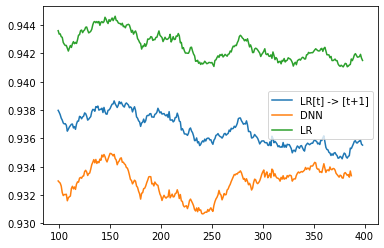

In [25]:
from sklearn import linear_model
import sklearn.metrics as metrics 
import matplotlib.pyplot as plt
import pandas as pd

def split_chunks(df, wg):
    chunks = df.shape[0] // wg.chunk_size
    result = []
    for chunk_id in range(chunks):
        result.append(df[chunk_id * wg.chunk_size:(chunk_id + 1) * wg.chunk_size])
        
    return result

val_df = split_chunks(wg_tmp.val_df, wg_tmp)
lr = linear_model.LogisticRegression()
lr.fit(val_df[1][wg_tmp.value_columns], val_df[1][wg_tmp.label_columns])
    
def measure_lr(lr, dat, rolling=100, weights=None):
    lr_aucs = []
    for lrp, df in dat:
        if weights != None:
            lr.coef_ = weights[:-1].reshape(1, -1).detach().numpy()
            lr.intercept_ = weights[-1].detach().numpy()
        else:
            lr.coef_ = lrp[:-1].reshape(1, -1).detach().numpy()
            lr.intercept_ = lrp[-1].detach().numpy()
        yhat = lr.predict_proba(df[wg_tmp.value_columns])
        lr_aucs.append(metrics.roc_auc_score(df[wg_tmp.label_columns], yhat[:, 1]))
    return pd.DataFrame(data=lr_aucs).rolling(rolling).mean()

def measure_model(model, dat, lr, rolling=100):
    model.eval()
    with torch.no_grad():
        model_aucs = []
        for (x, target), df in dat:
#             lrhat = model.forward(x).detach().numpy().reshape(-1) + target.detach().numpy().reshape(-1)
            lrhat = target.detach().numpy().reshape(-1)

            lr.coef_ = lrhat[:-1].reshape(1, -1)
            lr.intercept_ = lrhat[-1]
            
            yhat = lr.predict_proba(df[wg_tmp.value_columns])
            
            model_aucs.append(metrics.roc_auc_score(df[wg_tmp.label_columns], yhat[:, 1]))
        return pd.DataFrame(data=model_aucs).rolling(rolling).mean()
    
sample_len = 5000
    
dat = list(zip(wg_tmp.val_lr[:-1, 0, :], val_df[1:]))
plt.plot(measure_lr(lr, dat[:sample_len]), label='LR[t] -> [t+1]')

def prepare_model_input(wg, model):
    ts_chunks = []
    lr_pred = []
    x = []
    for k in range(len(wg.val_agges) - (model.conv_width + 1)):
        agg = wg.val_agges[k:k + model.conv_width, 0, :]
        lr_v  = wg.val_lr[k:k + model.conv_width, 0, :]
        target  = wg.val_lr[k + model.conv_width, 0, :]
        x.append(((agg.reshape(1, *agg.shape), lr_v.reshape(1, *lr_v.shape)), target))
        
    return x

x = prepare_model_input(wg_tmp, model)

dat = list(zip(x[:-1], val_df[1:]))
plt.plot(measure_model(model, dat[:sample_len], lr), label='DNN')

# dat = list(zip(wg_tmp.val_lr[:-1, 0, :], val_df[:-1]))
# plt.plot(measure_lr(lr, dat[:sample_len], weights=wg_tmp.val_lr[2, 0, :]), label='first val LR')

dat = list(zip(wg_tmp.val_lr[:-1, 0, :], val_df[:-1]))
plt.plot(measure_lr(lr, dat[:sample_len]), label='LR')


# dat = list(zip(wg_tmp.val_lr[:-1, 0, :], val_df[:-1]))
# plt.plot(measure_lr(lr, dat[:sample_len], weights=wg_tmp.train_lr[-1, 0, :]), label='last train LR')

plt.legend()

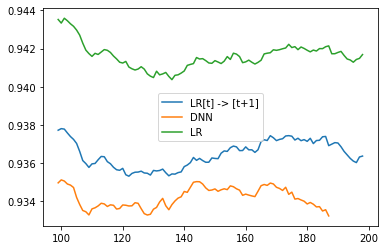

In [26]:
from sklearn import linear_model
import sklearn.metrics as metrics 
import matplotlib.pyplot as plt
import pandas as pd

def split_chunks(df, wg):
    chunks = df.shape[0] // wg.chunk_size
    result = []
    for chunk_id in range(chunks):
        result.append(df[chunk_id * wg.chunk_size:(chunk_id + 1) * wg.chunk_size])
        
    return result

test_df = split_chunks(wg_tmp.test_df, wg_tmp)
lr = linear_model.LogisticRegression()
lr.fit(test_df[1][wg_tmp.value_columns], test_df[1][wg_tmp.label_columns])
    
def measure_lr(lr, dat, rolling=100, weights=None):
    lr_aucs = []
    for lrp, df in dat:
        if weights != None:
            lr.coef_ = weights[:-1].reshape(1, -1).detach().numpy()
            lr.intercept_ = weights[-1].detach().numpy()
        else:
            lr.coef_ = lrp[:-1].reshape(1, -1).detach().numpy()
            lr.intercept_ = lrp[-1].detach().numpy()
        yhat = lr.predict_proba(df[wg_tmp.value_columns])
        lr_aucs.append(metrics.roc_auc_score(df[wg_tmp.label_columns], yhat[:, 1]))
    return pd.DataFrame(data=lr_aucs).rolling(rolling).mean()

def measure_model(model, dat, lr, rolling=100):
    model.eval()
    with torch.no_grad():
        model_aucs = []
        for (x, target), df in dat:
#             lrhat = model.forward(x).detach().numpy().reshape(-1) + target.detach().numpy().reshape(-1)
            lrhat = target.detach().numpy().reshape(-1)
    
            lr.coef_ = lrhat[:-1].reshape(1, -1)
            lr.intercept_ = lrhat[-1]
            
            yhat = lr.predict_proba(df[wg_tmp.value_columns])
            
            model_aucs.append(metrics.roc_auc_score(df[wg_tmp.label_columns], yhat[:, 1]))
        return pd.DataFrame(data=model_aucs).rolling(rolling).mean()
    
sample_len = 5000
    
dat = list(zip(wg_tmp.test_lr[:-1, 0, :], test_df[1:]))
plt.plot(measure_lr(lr, dat[:sample_len]), label='LR[t] -> [t+1]')

def prepare_model_input(wg, model):
    ts_chunks = []
    lr_pred = []
    x = []
    for k in range(len(wg.test_agges) - (model.conv_width + 1)):
        agg = wg.test_agges[k:k + model.conv_width, 0, :]
        lr_v  = wg.test_lr[k:k + model.conv_width, 0, :]
        target  = wg.test_lr[k + model.conv_width, 0, :]
        x.append(((agg.reshape(1, *agg.shape), lr_v.reshape(1, *lr_v.shape)), target))
        
    return x

x = prepare_model_input(wg_tmp, model)

dat = list(zip(x[:-1], test_df[1:]))
plt.plot(measure_model(model, dat[:sample_len], lr), label='DNN')

# dat = list(zip(wg_tmp.test_lr[:-1, 0, :], test_df[:-1]))
# plt.plot(measure_lr(lr, dat[:sample_len], weights=wg_tmp.test_lr[2, 0, :]), label='first test LR')

dat = list(zip(wg_tmp.test_lr[:-1, 0, :], test_df[:-1]))
plt.plot(measure_lr(lr, dat[:sample_len]), label='LR')


# dat = list(zip(wg_tmp.test_lr[:-1, 0, :], test_df[:-1]))
# plt.plot(measure_lr(lr, dat[:sample_len], weights=wg_tmp.train_lr[-1, 0, :]), label='last train LR')

plt.legend()

tensor([-0.0849, -0.0510, -0.0341, -0.0052, -0.0332, -0.0625,  0.0060,  0.0942,
         0.0362, -0.0078,  1.1280])

/home/rwiatr/anaconda3/envs/env-phd/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370117127/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


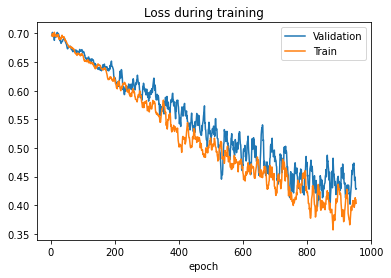

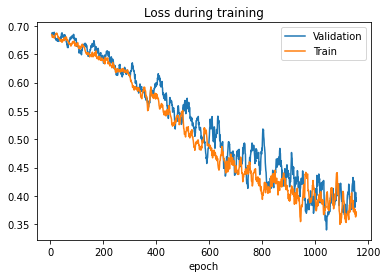

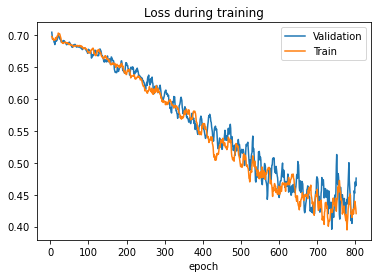

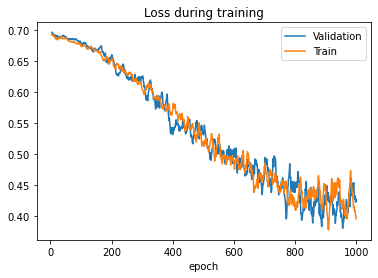

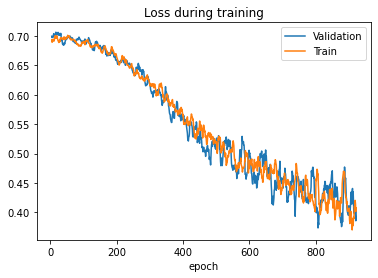

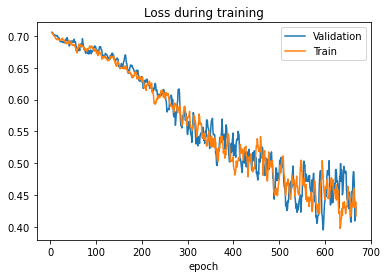

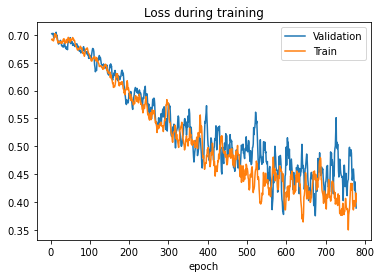

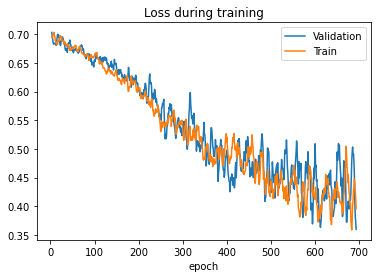

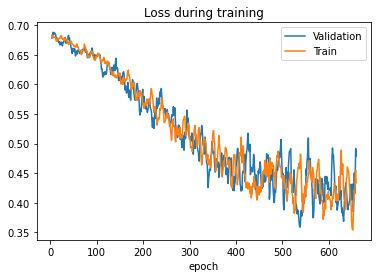

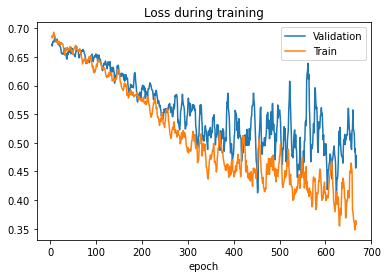

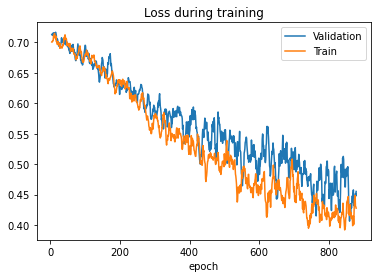

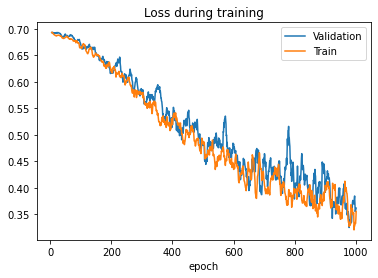

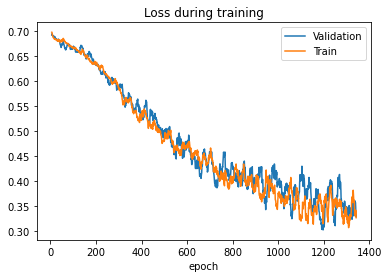

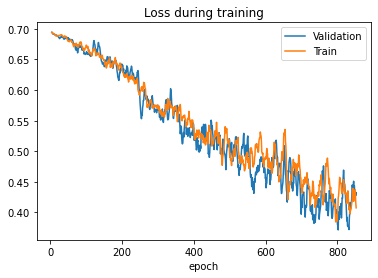

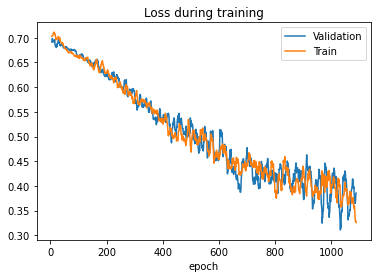

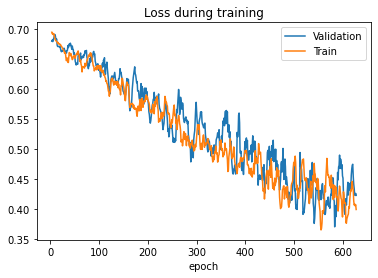

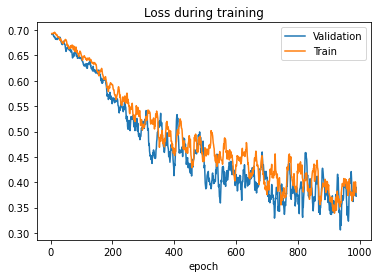

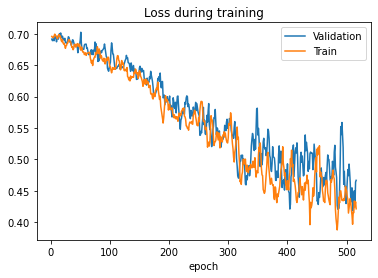

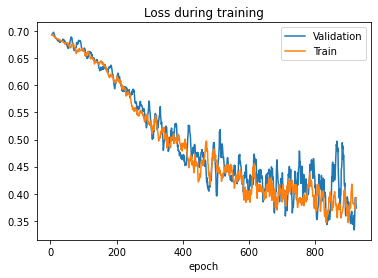

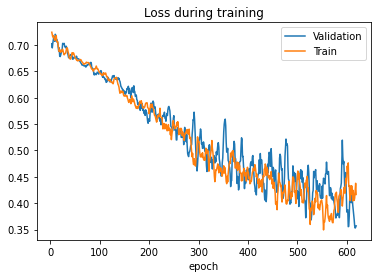

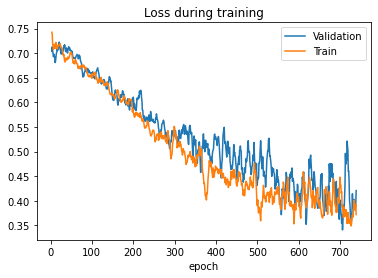

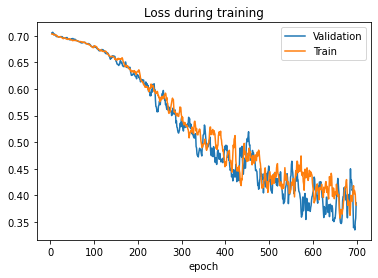

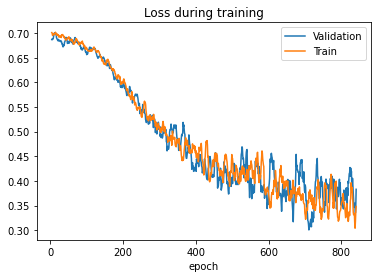

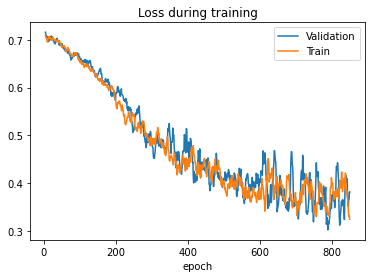

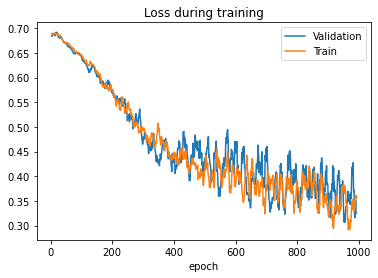

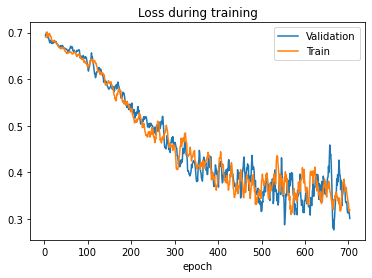

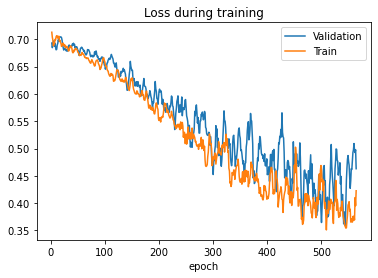

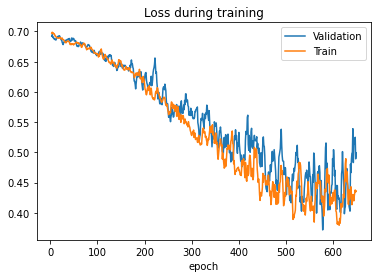

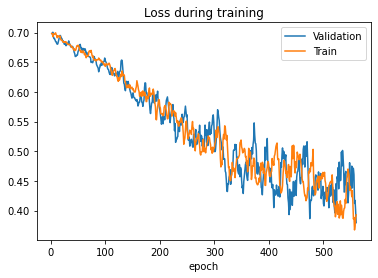

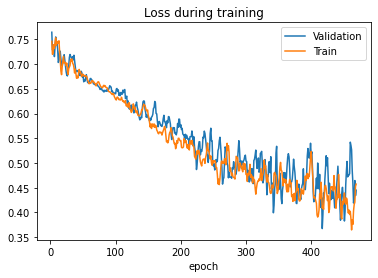

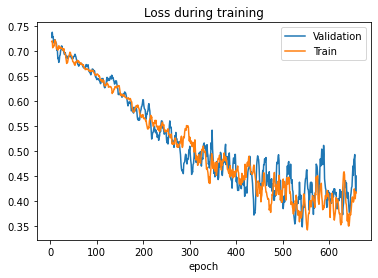

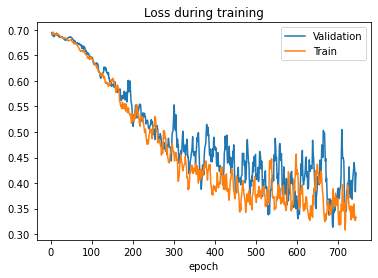

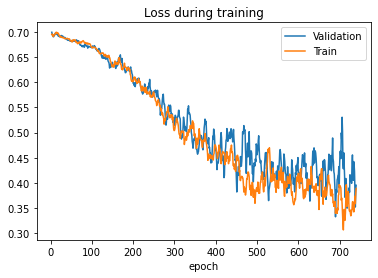

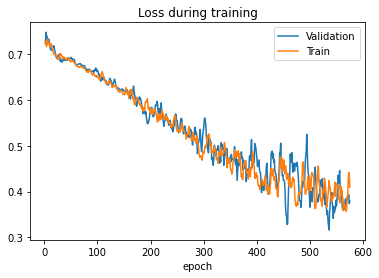

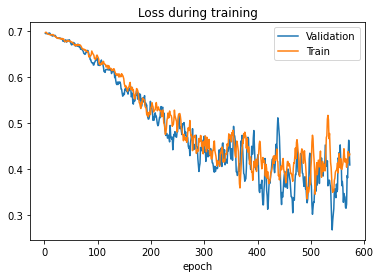

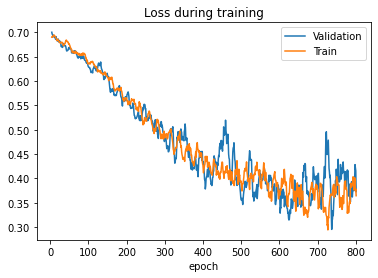

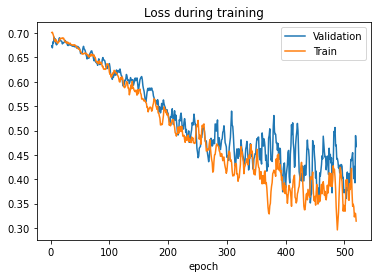

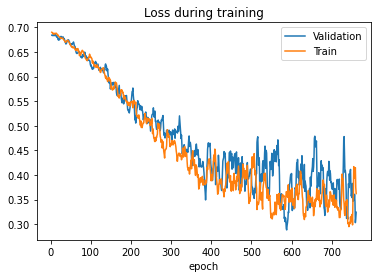

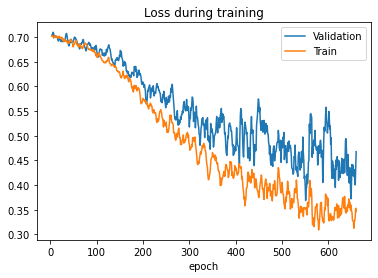

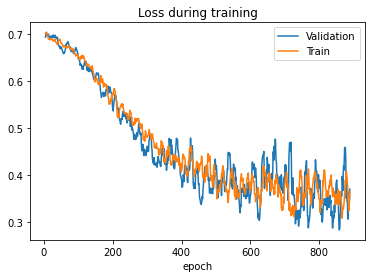

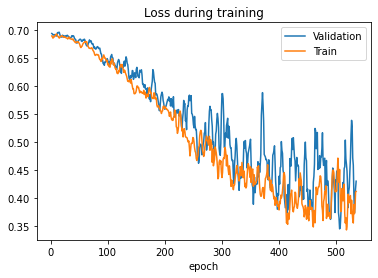

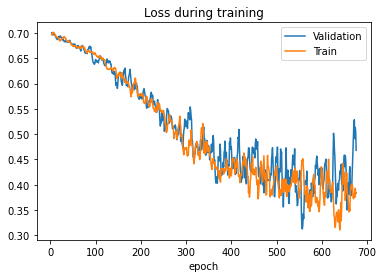

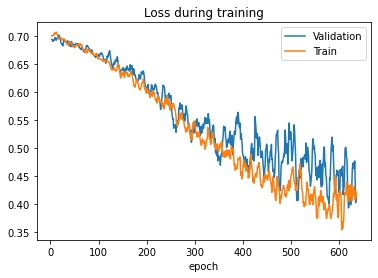

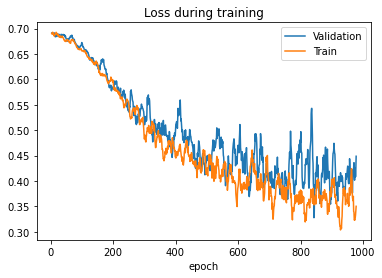

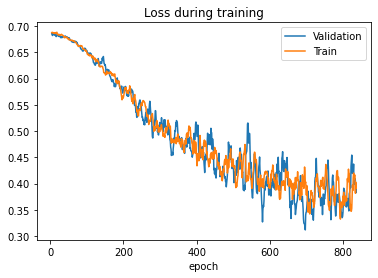

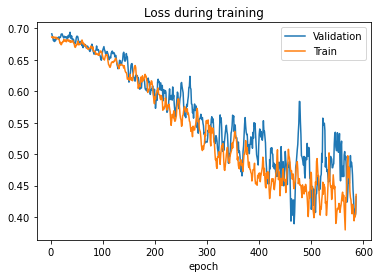

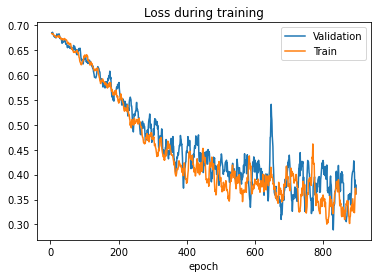

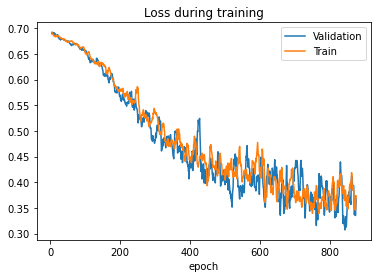

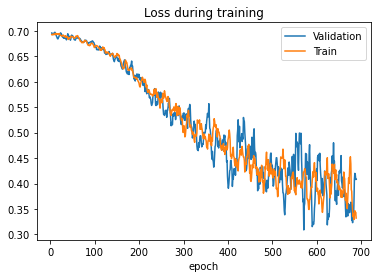

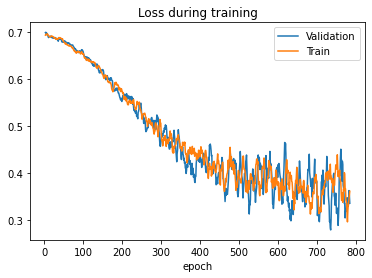

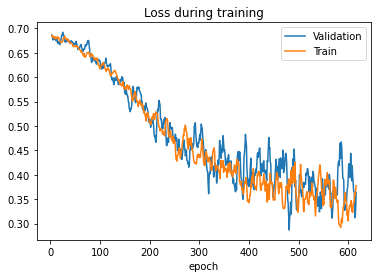

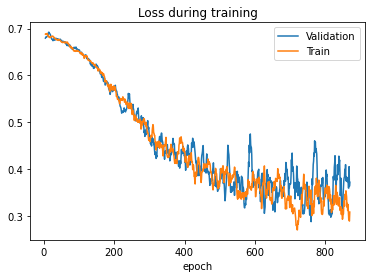

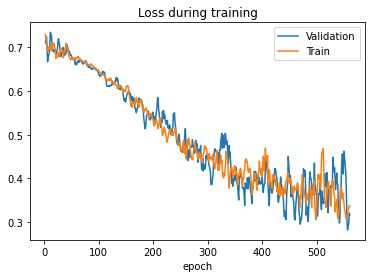

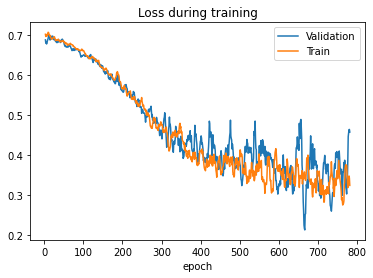

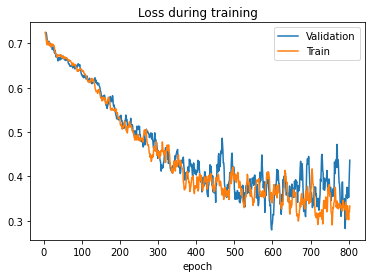

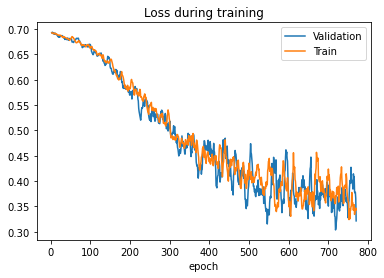

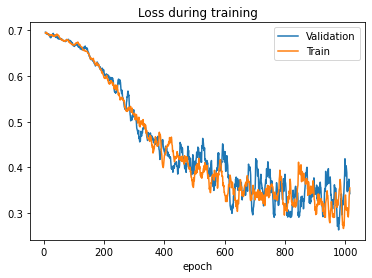

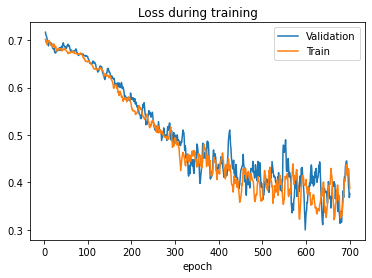

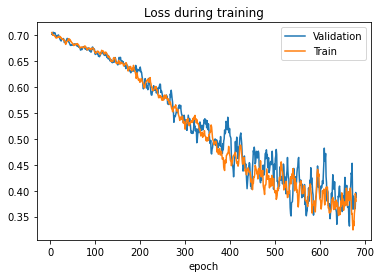

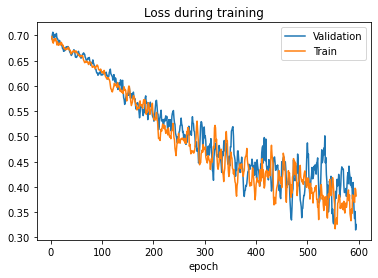

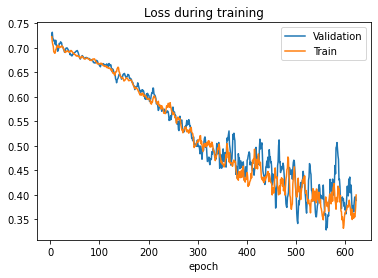

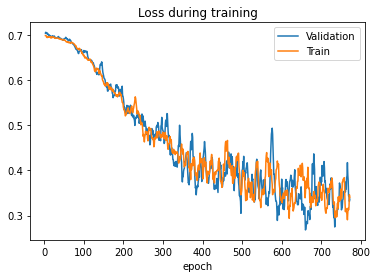

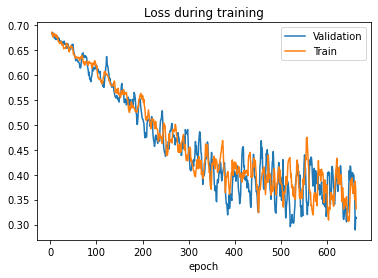

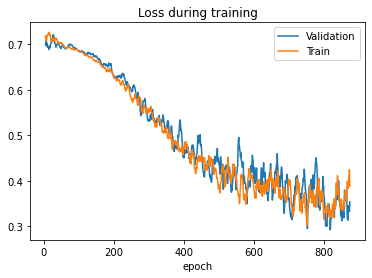

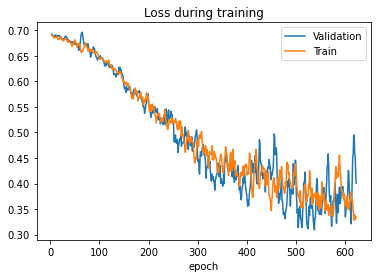

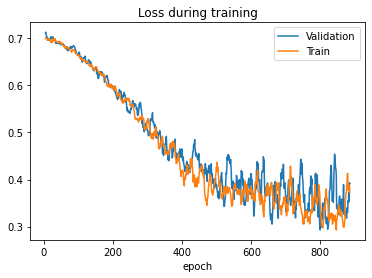

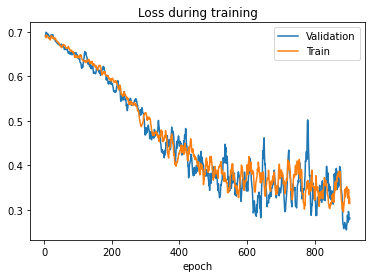

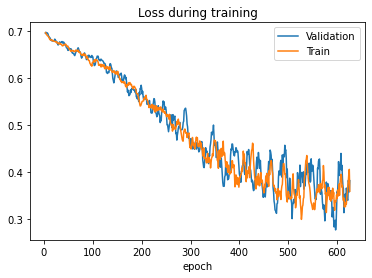

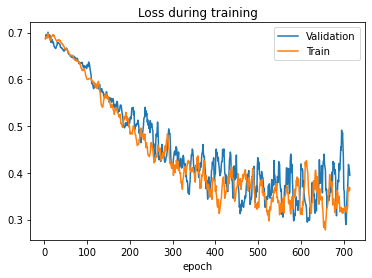

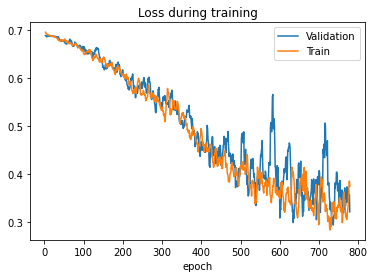

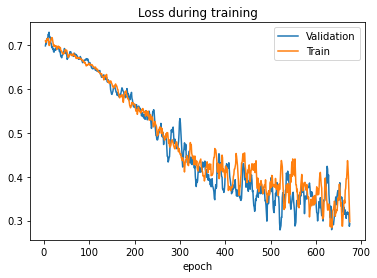

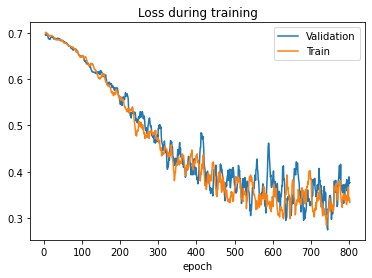

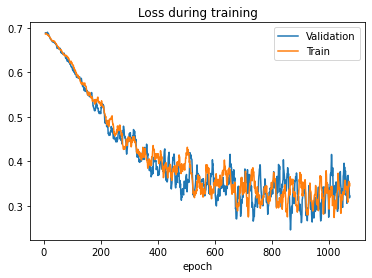

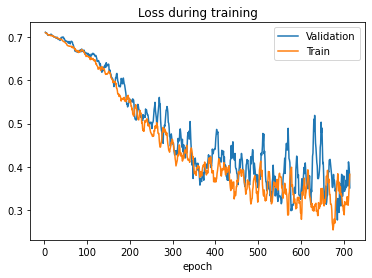

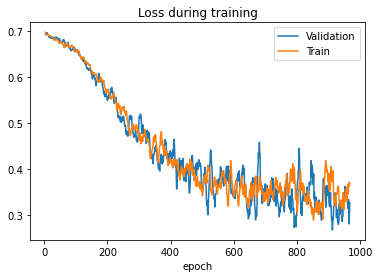

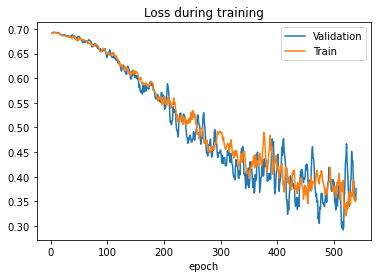

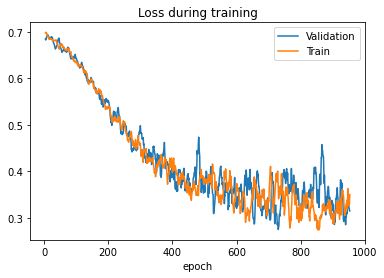

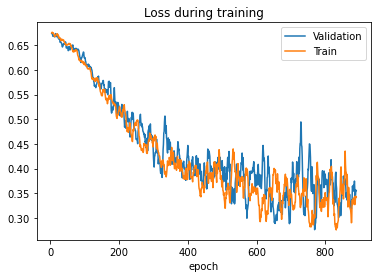

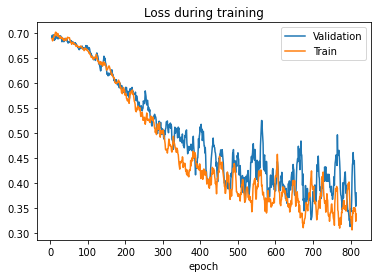

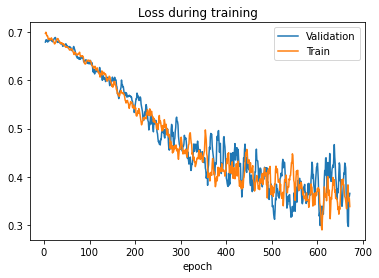

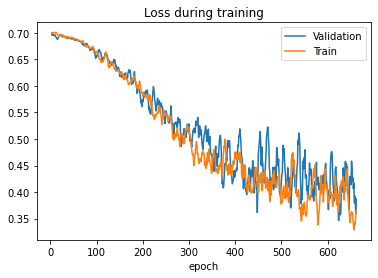

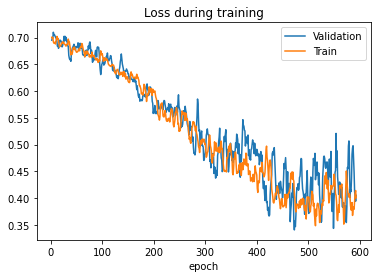

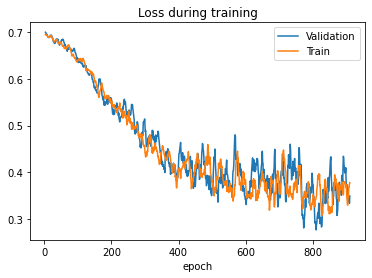

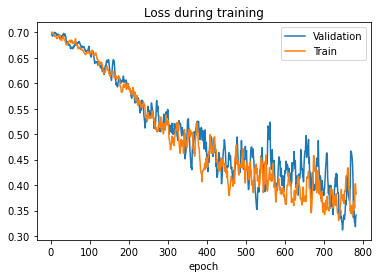

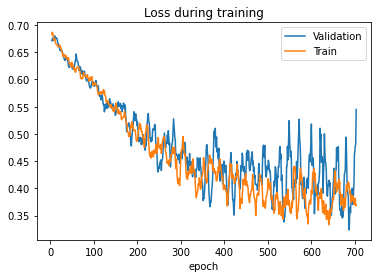

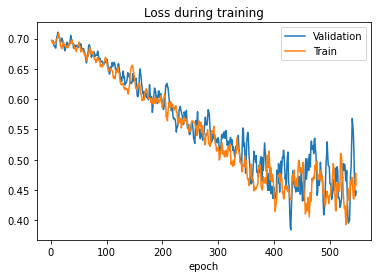

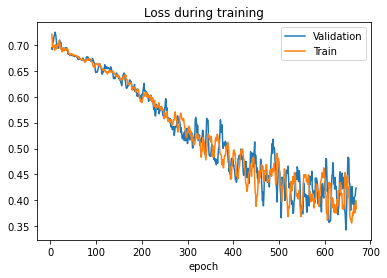

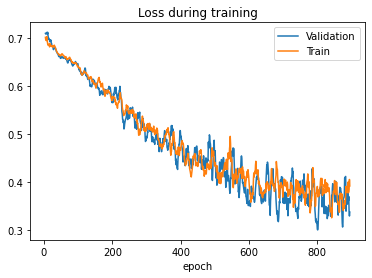

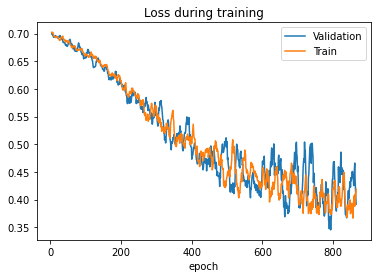

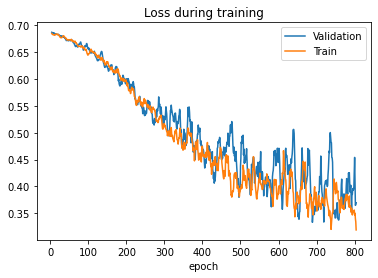

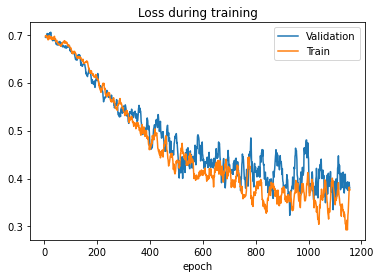

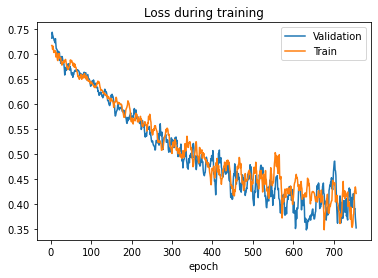

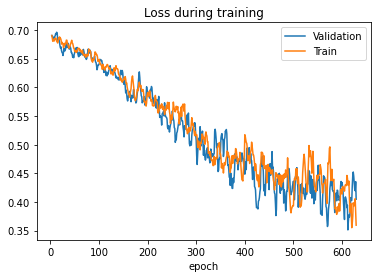

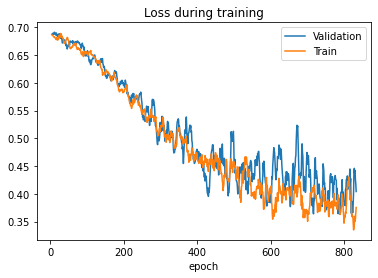

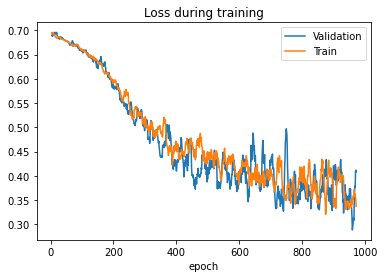

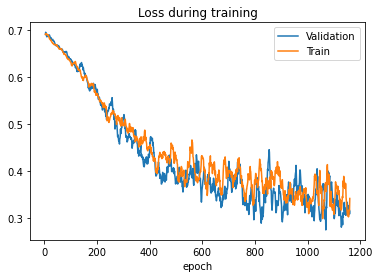

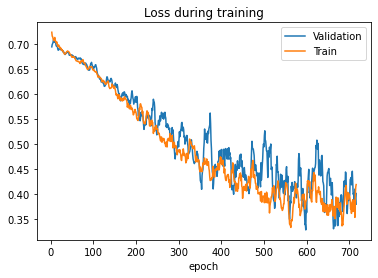

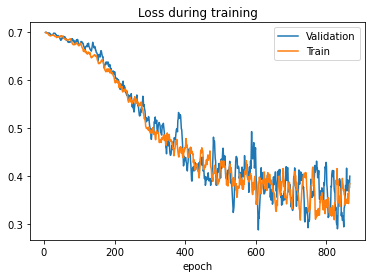

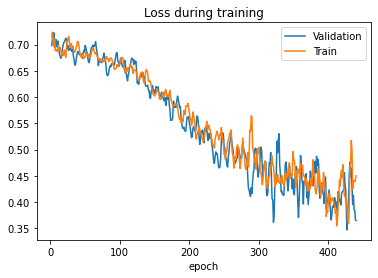

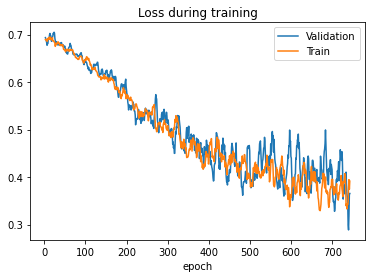

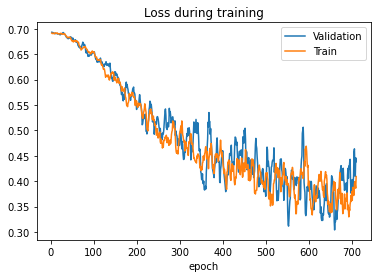

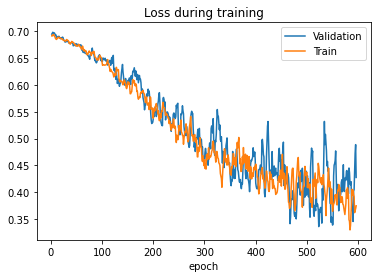

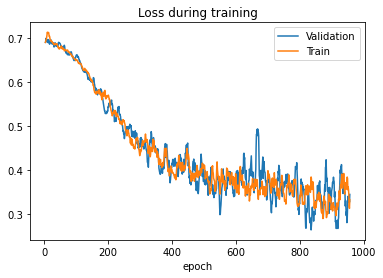

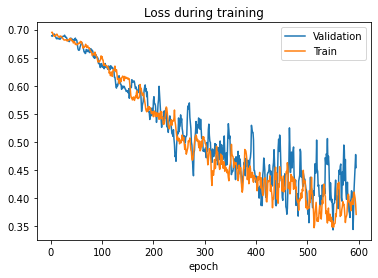

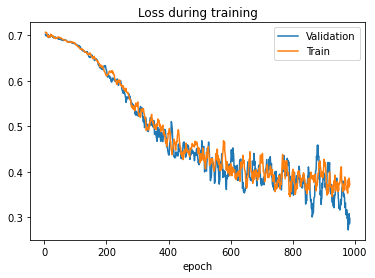

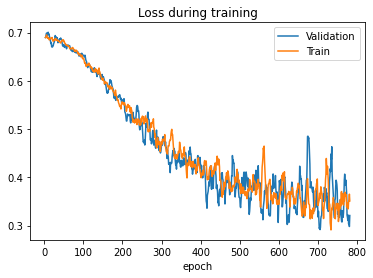

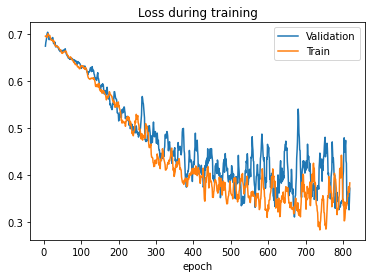

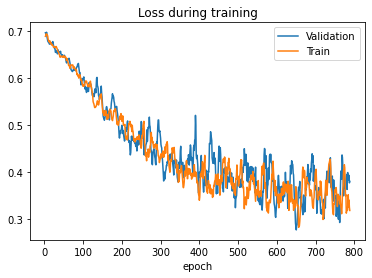

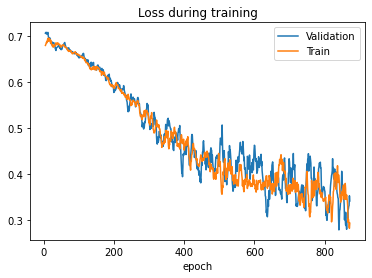

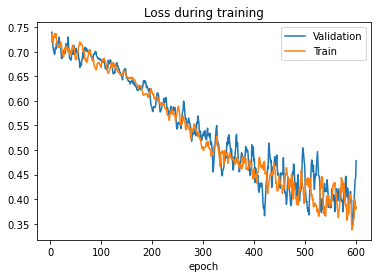

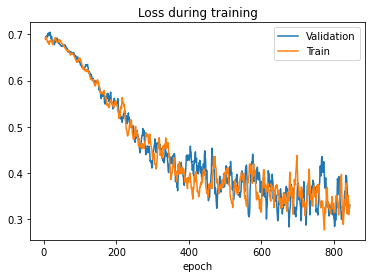

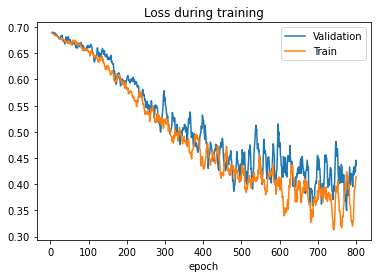

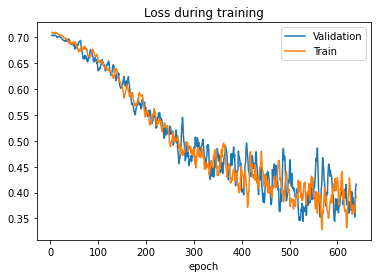

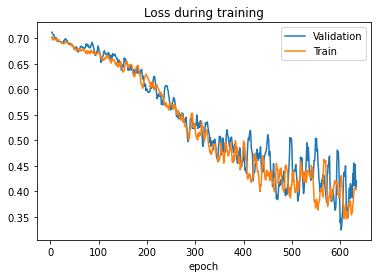

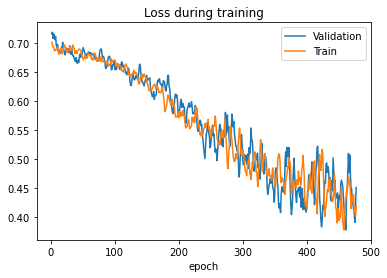

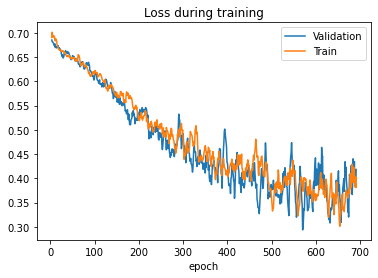

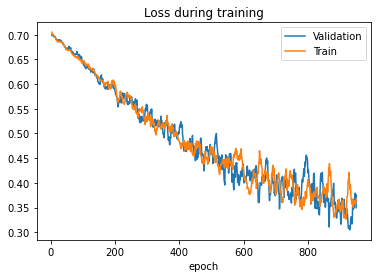

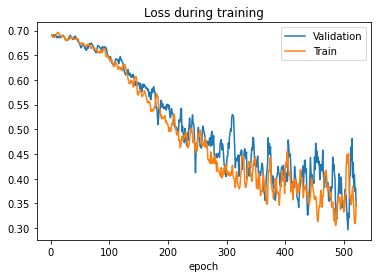

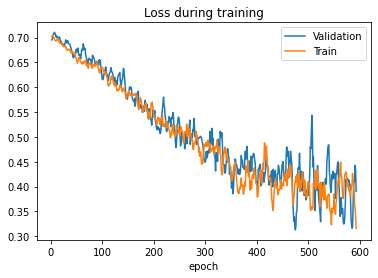

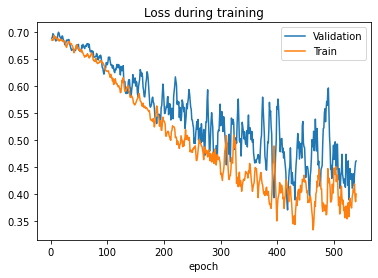

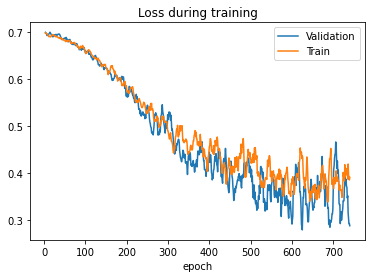

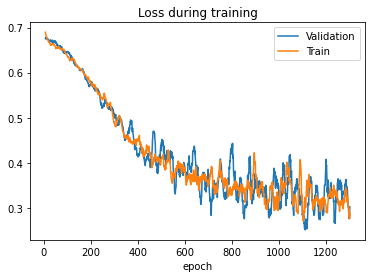

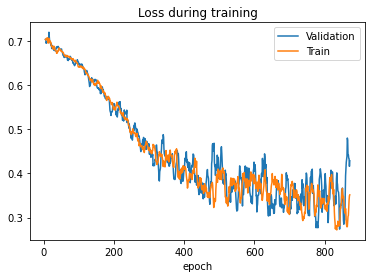

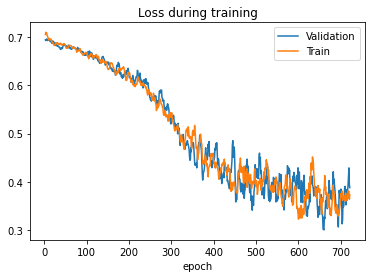

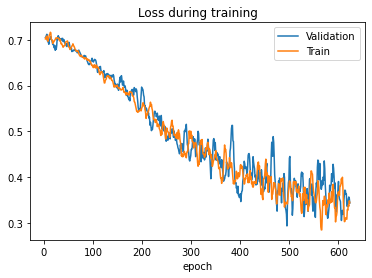

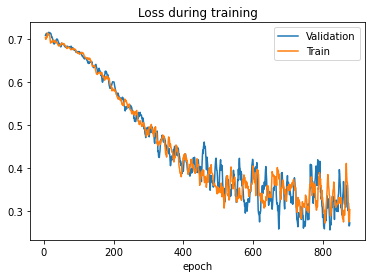

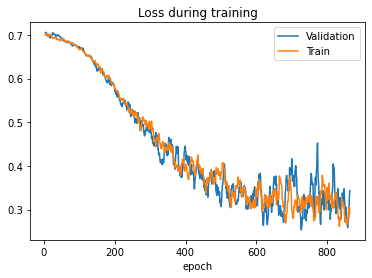

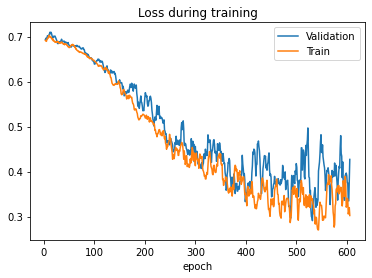

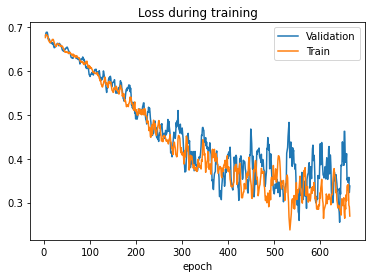

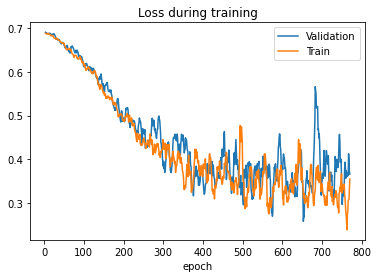

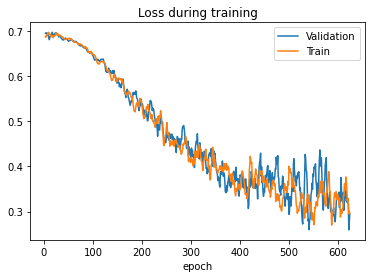

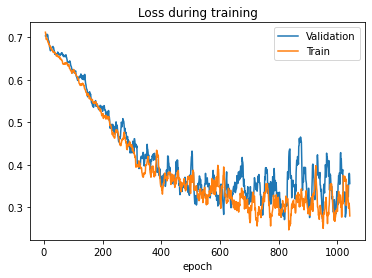

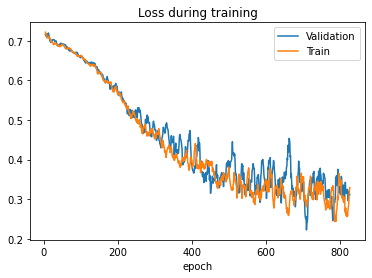

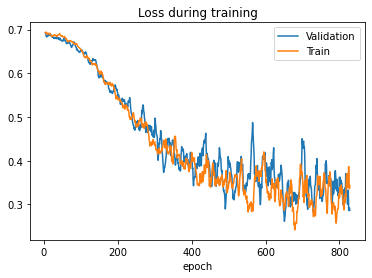

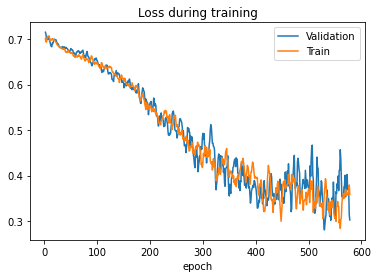

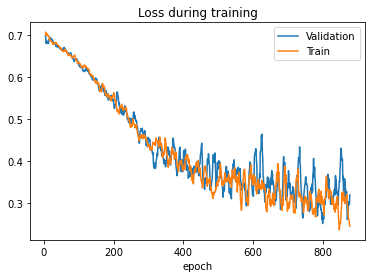

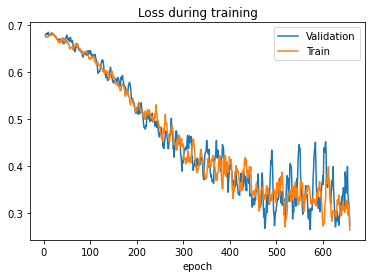

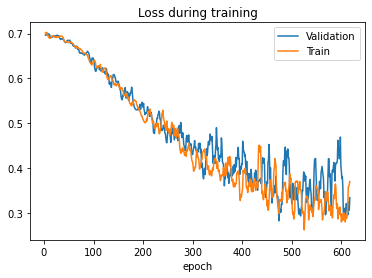

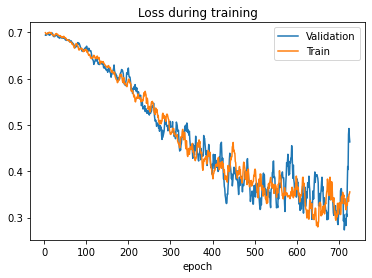

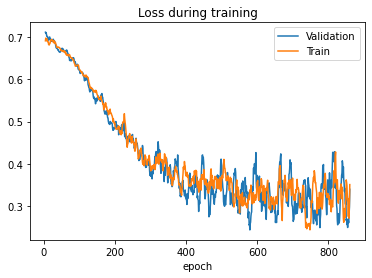

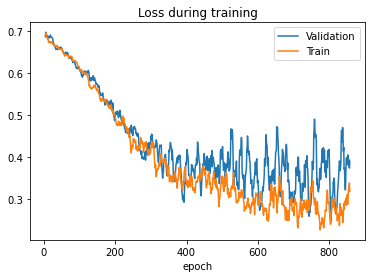

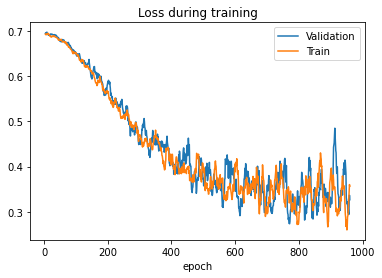

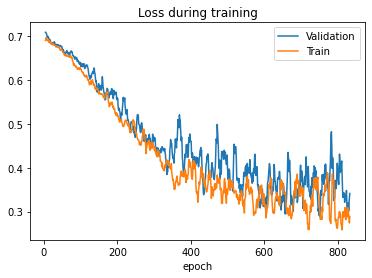

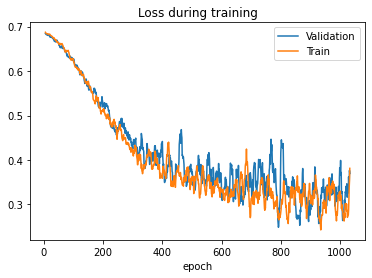

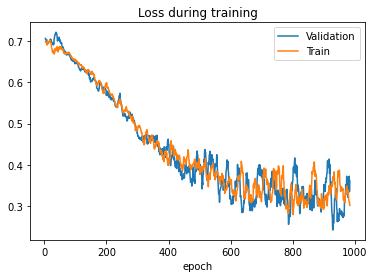

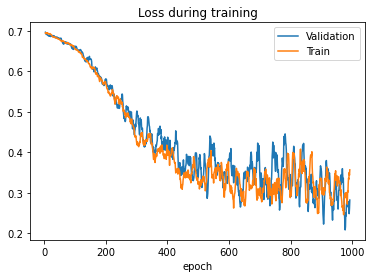

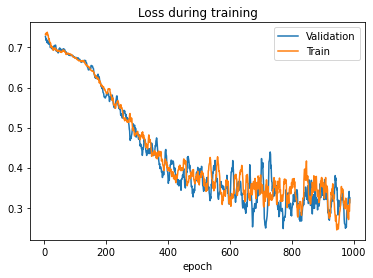

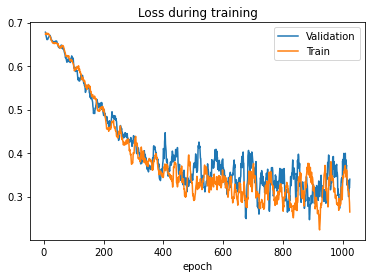

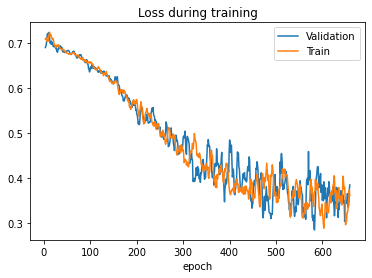

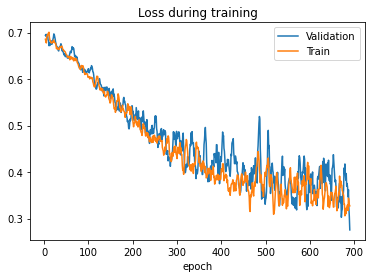

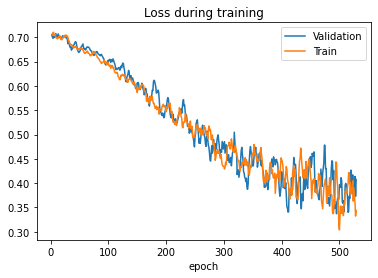

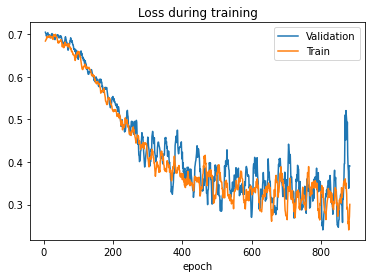

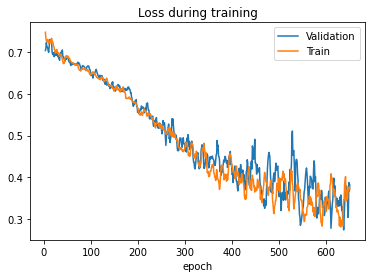

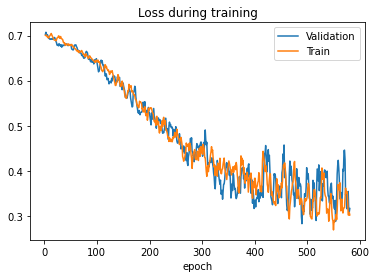

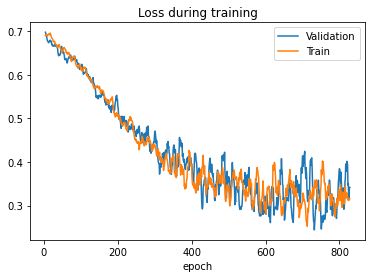

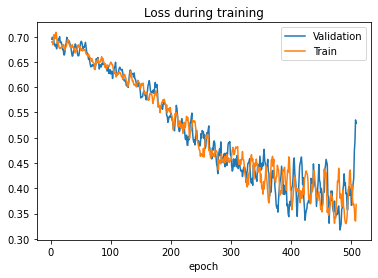

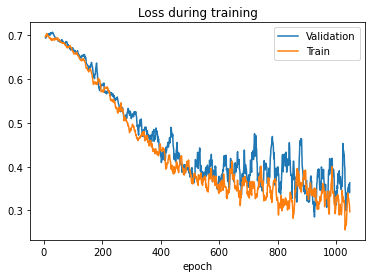

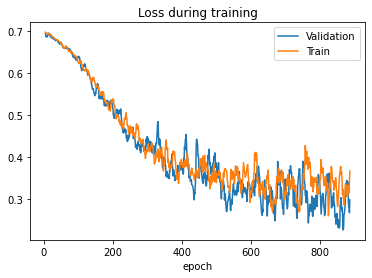

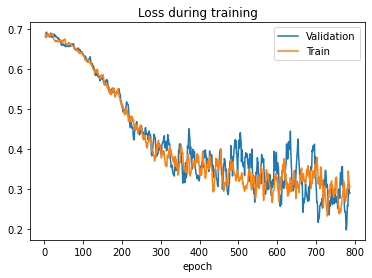

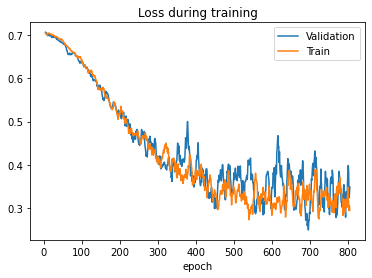

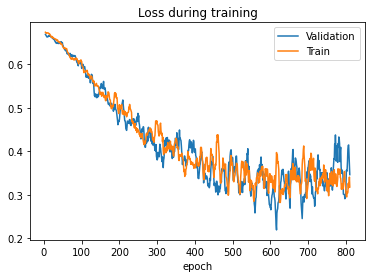

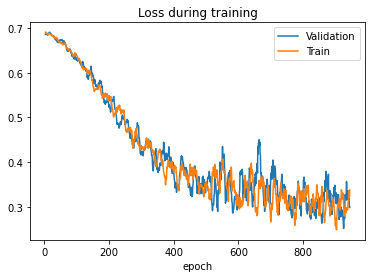

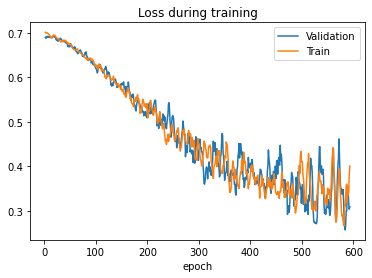

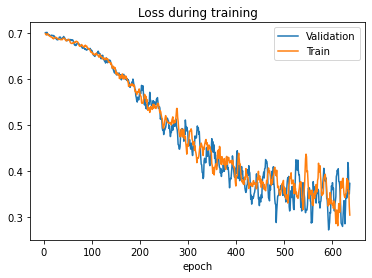

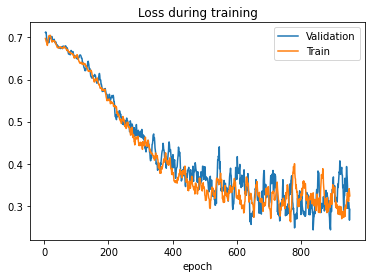

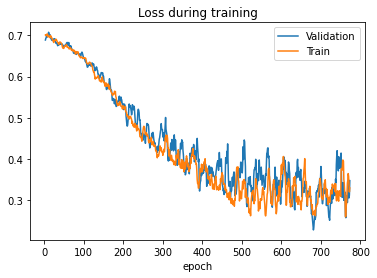

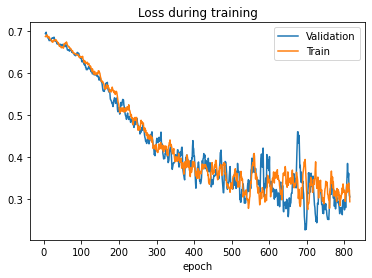

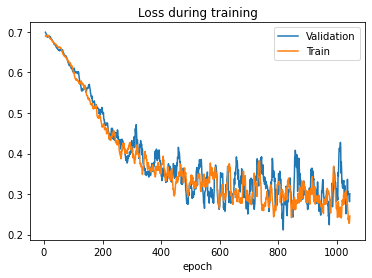

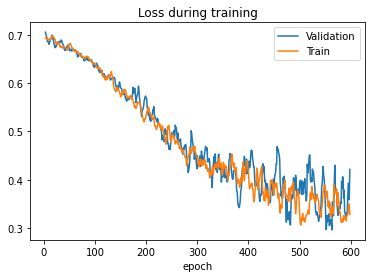

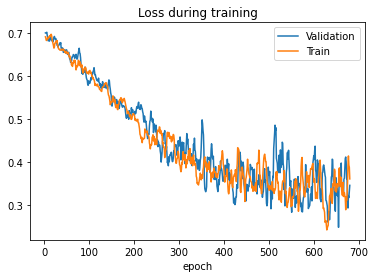

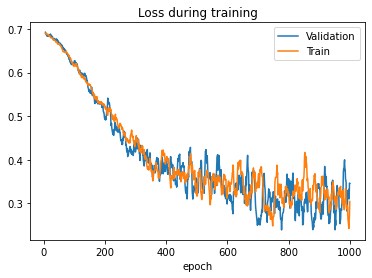

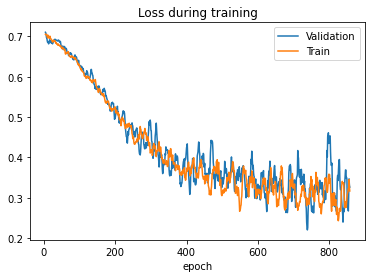

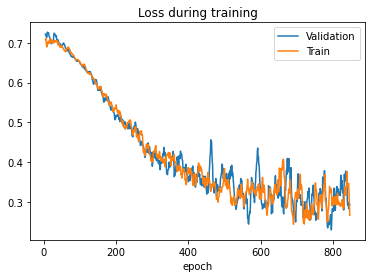

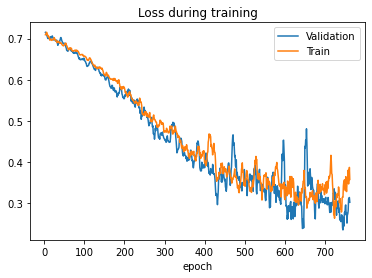

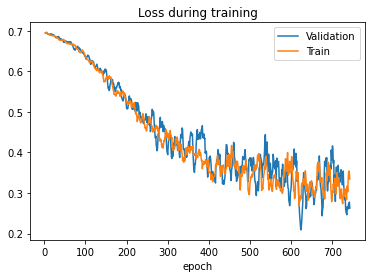

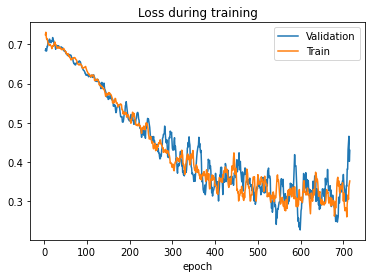

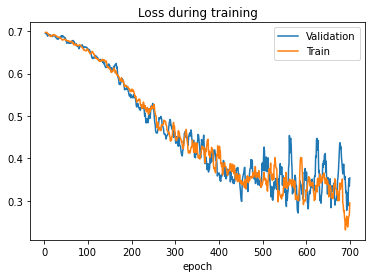

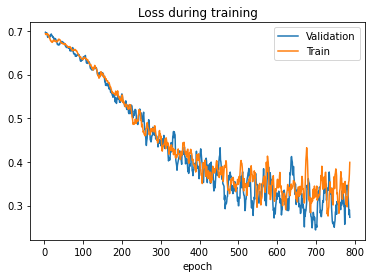

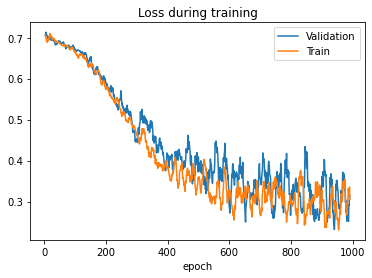

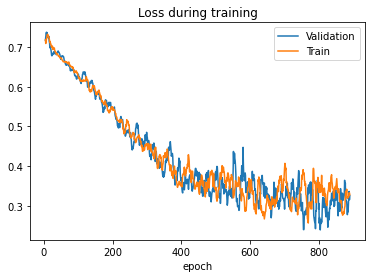

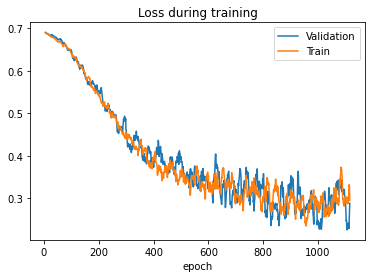

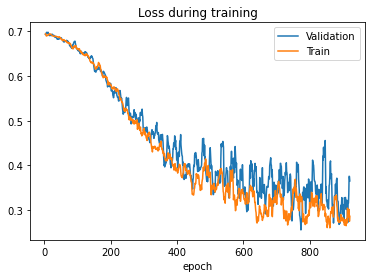

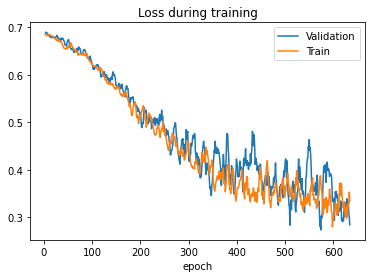

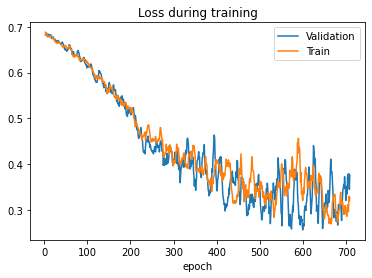

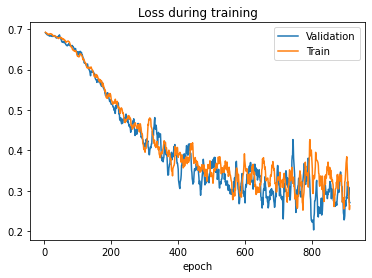

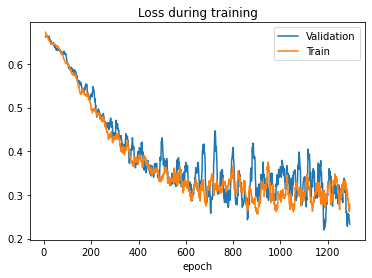

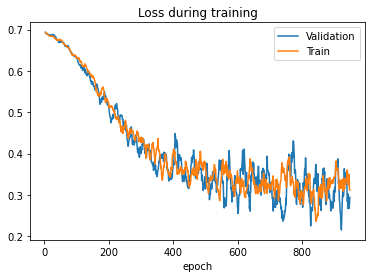

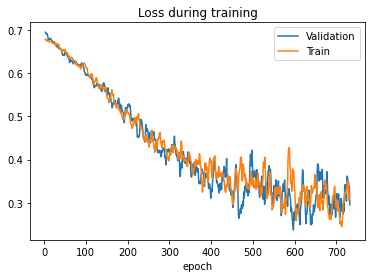

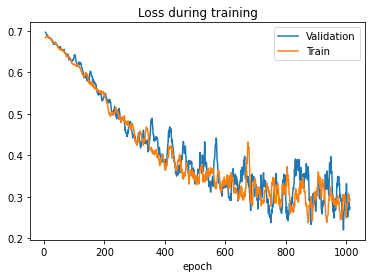

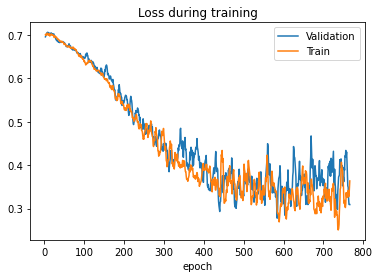

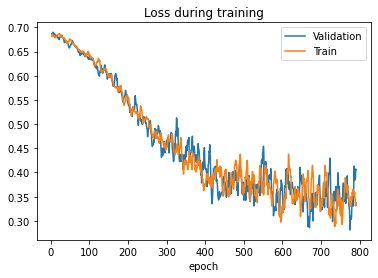

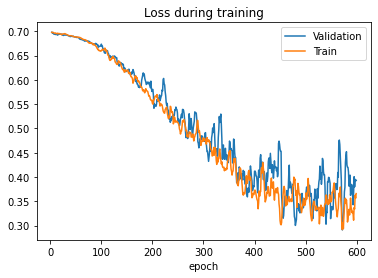

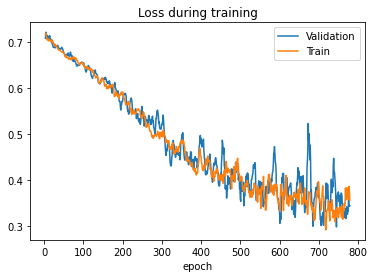

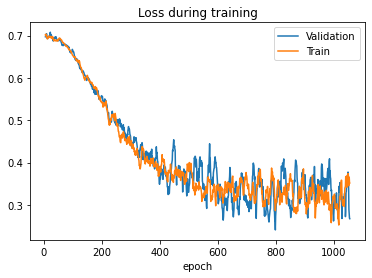

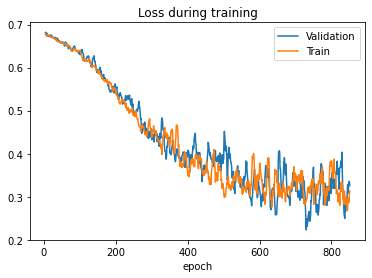

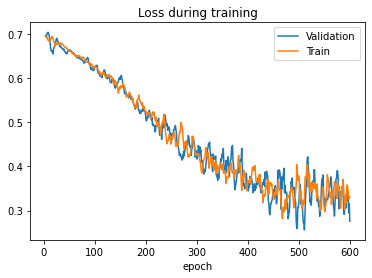

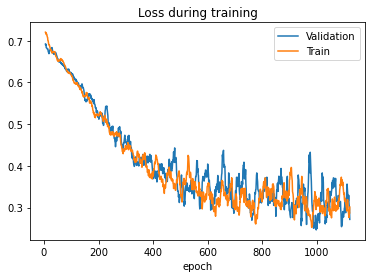

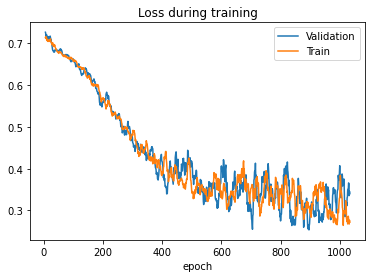

In [3]:
import aggets.model.simple as simple
import aggets.train as train


models = []
for w in wg.windows:
    model = simple.mlp(features=10, num_layers=2, hidden=10)
    bce = nn.BCEWithLogitsLoss()
    crit = lambda yhat, y: bce(yhat.view(-1), y.view(-1))
    train.train_model(model, w, log_every=4000, max_epochs=4000, criterion=crit, patience=120)
    plt.show()
    models.append(model)


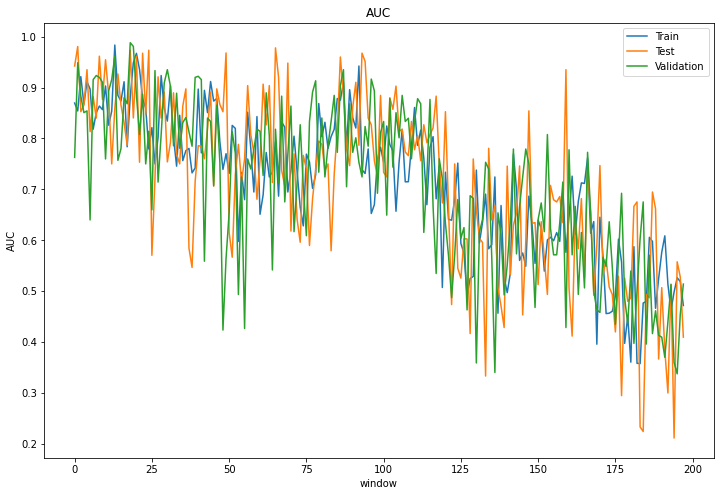

In [4]:
wg.plot(simple.classify(models[0]))

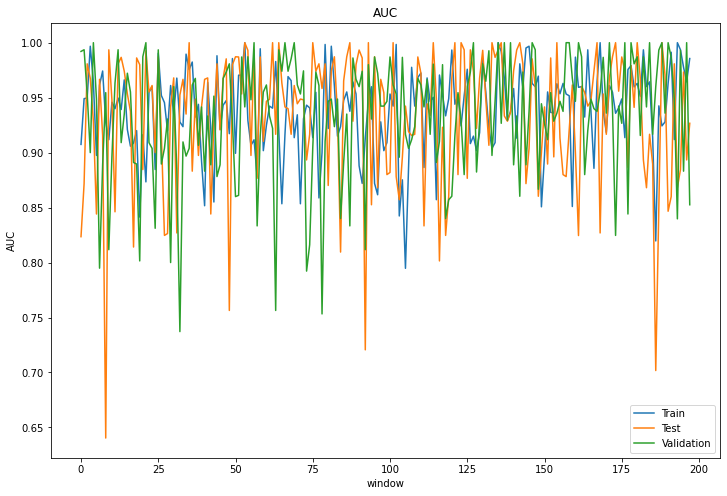

In [5]:
wg.plots([simple.classify(model) for model in models])

In [13]:
import aggets.agge as agge
enc = agge.AggregateEncoder()
df = data['df'][:1000]
array = enc.fit_transform(df.drop(columns=['class']), df['class'])

../aggets/agge.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_column['y'] = y
../aggets/agge.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_column['y'] = y
../aggets/agge.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_column['

In [20]:
import numpy as np
for feature in array:
    print(np.unique(feature))

[0.  0.5 1. ]
[0.  0.5 1. ]
[0.  0.5 1. ]
[0.  0.5 1. ]
[0.  0.5 1. ]
[0.         0.5        0.66666667 1.        ]
[0.  0.5 1. ]
[0.  0.5 1. ]
[0.  0.5 1. ]
[0.  0.5 1. ]


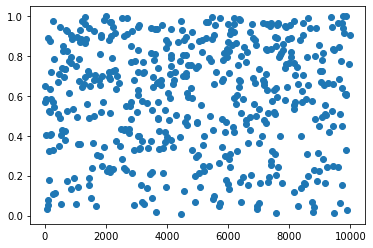

In [45]:
# df['att1'].scatter()

import matplotlib.pyplot as plt
tmp = df.sample(frac=0.1)#[1000:1100]
plt.scatter(tmp[tmp['class'] == 1].index, tmp[tmp['class'] == 1]['att7'])
# plt.scatter(tmp[tmp['class'] == 0].index, tmp[tmp['class'] == 0]['att2'])
plt.show()

In [53]:
from sklearn import linear_model
lr = linear_model.LogisticRegression()
lr.fit(df[:100][['att1']], df[:100]['class'])
lr.predict_proba(df[:100][['att1']])[:, 1]

array([0.46097479, 0.43026533, 0.41984764, 0.43099096, 0.4252512 ,
       0.39684461, 0.57547351, 0.50179116, 0.47461888, 0.58249936,
       0.45292423, 0.4407755 , 0.52216096, 0.61013314, 0.53321798,
       0.40088177, 0.5615848 , 0.48926738, 0.37772553, 0.54248462,
       0.46978692, 0.42848635, 0.37948378, 0.45462247, 0.37903943,
       0.59449024, 0.47996429, 0.46260986, 0.37873324, 0.45182714,
       0.41256508, 0.45059819, 0.6081276 , 0.49876524, 0.45639021,
       0.55089039, 0.52264382, 0.52575685, 0.54712675, 0.4353789 ,
       0.57957921, 0.540417  , 0.54649454, 0.42041313, 0.41534727,
       0.45405913, 0.43558638, 0.50799351, 0.53954757, 0.50286137,
       0.48610672, 0.5640482 , 0.58330726, 0.37030902, 0.53148134,
       0.51067159, 0.38618048, 0.36744901, 0.60290951, 0.55225367,
       0.37321435, 0.58342208, 0.4402822 , 0.58665902, 0.41057933,
       0.60710549, 0.60635561, 0.51512998, 0.39683242, 0.4037915 ,
       0.3937861 , 0.5589043 , 0.37460404, 0.43681345, 0.41084

In [7]:
import aggets.agge as agge
import aggets.ds.hyper_f_load as hyper_f_load

data = hyper_f_load.load_discrete_df()
df = data['df']

enc = agge.AggregateEncoder()
enc.fit(df.drop(columns=['class']), df['class'], bin_count=3)
# encoded = np.concatenate(array, axis=1)

../aggets/agge.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  feature_column['y'] = y
../aggets/agge.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  feature_column['y'] = y
../aggets/agge.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  feature_column['y'] = y
../aggets/agge.py:17: SettingWithCopyWarnin

In [24]:
import numpy as np
np.concatenate((enc.models['att1'].to_numpy().reshape(30), enc.models['att1'].to_numpy().reshape(-1)))

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.15100305,
       0.        , 0.        , 0.        , 0.        , 0.50485436,
       0.46603436, 0.        , 0.        , 0.        , 0.8138911 ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 1.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.15100305,
       0.        , 0.        , 0.        , 0.        , 0.50485436,
       0.46603436, 0.        , 0.        , 0.        , 0.8138911 ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 1.        , 1.        , 0.        , 0.        ])

In [36]:
np.pad(enc.models['att1'].to_numpy().reshape(30), 35, mode='constant', constant_values=0)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.15100305,
       0.        , 0.        , 0.        , 0.        , 0.50485436,
       0.46603436, 0.        , 0.        , 0.        , 0.8138911 ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 1.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [50]:
import pandas as pd

total_size = encoded.shape[0]
encoded = pd.DataFrame(data=encoded, columns=[f'c_{i}' for i in range(10)])
train = encoded[0:total_size//2]
test = encoded[total_size//2:total_size//2 + total_size//4]
val = encoded[total_size//2 + total_size//4:]

In [51]:
CONV_WIDTH = 10
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

conv_window = window.WindowGenerator(
    train_df = train,
    val_df = test,
    test_df = val,
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1
)
conv_window

Total window size: 34
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
Label indices: [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33]
Label column name(s): None

epoch 0 batch 1000 loss=0.0683, MTL=0.0789, MVL=nan				
epoch 0 batch 2000 loss=0.0676, MTL=0.0738, MVL=nan				
epoch 0 batch 3000 loss=0.0679, MTL=0.0722, MVL=nan				
epoch 0 batch 4000 loss=0.0685, MTL=0.0713, MVL=nan				
epoch 0 batch 5000 loss=0.0678, MTL=0.0708, MVL=nan				
epoch 0 batch 6000 loss=0.0678, MTL=0.0704, MVL=nan				
epoch 0 batch 7000 loss=0.0679, MTL=0.0702, MVL=nan				
epoch 0 batch 8000 loss=0.0677, MTL=0.07, MVL=nan				
epoch 0 batch 9000 loss=0.0685, MTL=0.0699, MVL=nan				
epoch 0 batch 10000 loss=0.0682, MTL=0.0698, MVL=nan				
epoch 0 batch 11000 loss=0.0679, MTL=0.0697, MVL=nan				
epoch 0 batch 12000 loss=0.0677, MTL=0.0696, MVL=nan				
epoch 0 batch 13000 loss=0.068, MTL=0.0695, MVL=nan				
epoch 0 batch 14000 loss=0.0689, MTL=0.0695, MVL=nan				
epoch 0 batch 15000 loss=0.068, MTL=0.0694, MVL=nan				
epoch 1 batch 16000 loss=0.0682, MTL=0.0687, MVL=0.0687				
epoch 1 batch 17000 loss=0.069, MTL=0.0687, MVL=0.0687				
epoch 1 batch 18000 loss=0.0692, MTL=0.

epoch 8 batch 139000 loss=0.0686, MTL=0.0687, MVL=0.0687				
epoch 8 batch 140000 loss=0.0683, MTL=0.0687, MVL=0.0687				
epoch 9 batch 141000 loss=0.0672, MTL=0.0687, MVL=0.0687				
epoch 9 batch 142000 loss=0.0681, MTL=0.0687, MVL=0.0687				
epoch 9 batch 143000 loss=0.0681, MTL=0.0687, MVL=0.0687				
epoch 9 batch 144000 loss=0.0687, MTL=0.0687, MVL=0.0687				
epoch 9 batch 145000 loss=0.0695, MTL=0.0687, MVL=0.0687				
epoch 9 batch 146000 loss=0.0686, MTL=0.0687, MVL=0.0687				
epoch 9 batch 147000 loss=0.0694, MTL=0.0687, MVL=0.0687				
epoch 9 batch 148000 loss=0.0689, MTL=0.0687, MVL=0.0687				
epoch 9 batch 149000 loss=0.0685, MTL=0.0687, MVL=0.0687				
epoch 9 batch 150000 loss=0.0697, MTL=0.0687, MVL=0.0687				
epoch 9 batch 151000 loss=0.0677, MTL=0.0687, MVL=0.0687				
epoch 9 batch 152000 loss=0.068, MTL=0.0687, MVL=0.0687				
epoch 9 batch 153000 loss=0.0692, MTL=0.0687, MVL=0.0687				
epoch 9 batch 154000 loss=0.0686, MTL=0.0687, MVL=0.0687				
epoch 9 batch 155000 loss

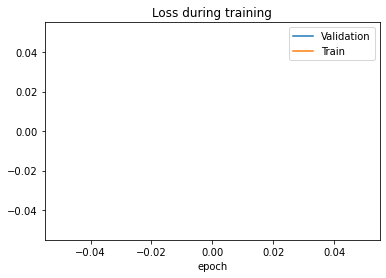

In [52]:
import aggets.train as train
import aggets.model.simple as simple

model = simple.conv_1d(CONV_WIDTH, features=10, hidden=10, out_features=10)
train.train_window_model(model, conv_window, max_epochs=100, patience=5)

In [54]:
# select window [      train  ]
# divide window [     [T][T+1]]
# aggregate [:T+1]
# 

In [5]:
np.array_split(data['df'], 1000)[-1].shape

(1000, 11)